# Subsampling mocks
Using Mehdi's [code](https://github.com/mehdirezaie/LSSutils/blob/master/analysis/lssxcmb/scripts/subsample_mock.py).

In [1]:
# %matplotlib inline
import healpy as hp
import numpy as np
import fitsio as ft
import matplotlib.pyplot as plt
from glob import glob

In [2]:
def radec2hpix(nside, ra, dec):
    """ change ra,dec to HEALPix hpix with ring ordering """
    theta, phi = np.deg2rad(90.-dec), np.deg2rad(ra)
    hpix = hp.ang2pix(nside, theta, phi, nest=False)     
    return hpix

def project2hp(nside, mock, weight=None):
    """ count # of objects in HEALPix """
    ra = mock['RA']
    dec = mock['DEC']
    hpix = radec2hpix(nside, ra, dec)
    return np.bincount(hpix, weights=weight, minlength=12*nside*nside)

def downsample(selection_func, mock):
    """ downsample a mock catalog with a given selection function """
    nside = hp.get_nside(selection_func)
    hpix = radec2hpix(nside, mock['RA'], mock['DEC'])
    prob = selection_func[hpix]    
    good = np.random.uniform(size=mock.size) < prob
    return mock[good]



In [3]:
# read the mock catalog and selection function (obtained from real data)
#mock = ft.read('/global/cfs/cdirs/desi/cosmosim/FirstGenMocks/AbacusSummit/CutSky/LRG/z0.800/')
ngal_pred = hp.read_map('/global/cscratch1/sd/arosado/test_sysnet/windows_clean/nn-weights.hp256.fits')

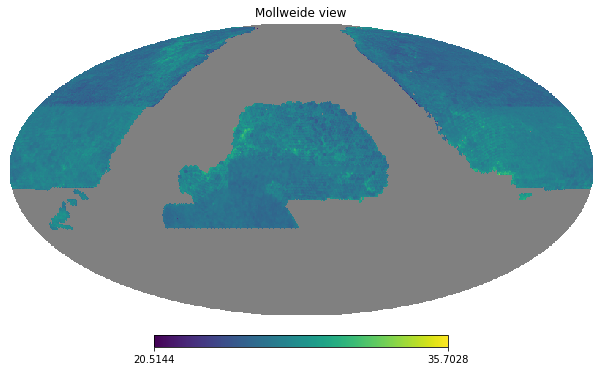

In [4]:
hp.mollview(ngal_pred)

In [5]:
# get nside from the selection function
nside = hp.get_nside(ngal_pred)

In [6]:
# normalize the selection function to [0, 1]
good = ngal_pred>0
vmin, vmax = np.percentile(ngal_pred[good], [0, 100])
selection_func = np.zeros_like(ngal_pred)
selection_func[good] = (ngal_pred[good]-vmin) / (vmax-vmin)

In [12]:
# subsample the mock catalog, and project to HEALPix
mock_after = downsample(selection_func, mock)
mock_hp = project2hp(nside, mock)
mock_hp_after = project2hp(nside, mock_after)

NameError: name 'mock' is not defined

In [ ]:
#
fig, ax = plt.subplots(nrows=3, figsize=(15, 20))
for i, (mapi, title) in enumerate(zip([mock_hp, selection_func, mock_hp_after],
                                      ['Clean Mock', 'Selection Func.', 'Cont. Mock'])):
    plt.sca(ax[i])        
    hp.mollview(mapi, title=title, hold=True, rot=-85)